In [122]:
# Set up & handling the data
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action="ignore")

# Cleaning the data
import re

# Transforming the data
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import ensemble   # we'll use ensemble random forests, gradient booster regressor


# Running the models
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression

#Statistics
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt


# Not using these yet
                                 # clean data
# from sklearn import linear_model
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import normalize
# import statsmodels.formula.api as smf
# from sqlalchemy import create_engine
# from scipy.stats import bartlett
# from scipy.stats import levene
# from statsmodels.tsa.stattools import acf
# import statsmodels.api as sm




# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [123]:
from platform import python_version

print(python_version())
# pip install xgboost

3.7.3


## Introduction

Analyzing the [IMDB Movie dataset](https://www.kaggle.com/jyoti1706/imdbmoviesdataset), I'm going to look at if we can predict how successful a movie is using the adjusted revenue as the measure of success. With nearly 11,000 movies and twenty variables, I should be able to choose features correlated with the revenue to create a good model. 

## Cleaning

There are 6,016 rows with an adjused revenue of $0. I'm going to remove these rows as 

Columns homepage, director, cast, keywords, tagline, and production_companies are missing values. For the homepage column, I will assumme that a missing value indicates that a movie does not have a homepage. I'll create a dummy variable in which 0 indicates there is no homepage and 1 indicates that one exists. Only one movie is missing the director and five movies are missing the cast, so I will look up this information and manually add it to the dataset. I will set cells missing values for keywords, tagline, and production companies to 'Unknown'.

Off the bat, popularity, budget, revenue, runtime, and votecount have clear high outliers. I'm going to take a look at these columns and see if we can derive what may be going on. Cast, homepage, director, tagline, keywords, overview, genres, and production_companies are missing values. Nearly all of these contain categorical data so I will fill the values as best as I can and remove rows and/or columns I cannot. 



In [124]:
movies = pd.read_csv('IMDBMovies.csv', encoding = 'utf-8')
movies = pd.DataFrame(movies)
print(movies.columns)
print('\n', movies.describe())
movies.info()

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

               id  popularity        budget        revenue   runtime  \
count  10866.000   10866.000     10866.000      10866.000 10866.000   
mean   66064.177       0.646  14625701.094   39823319.793   102.071   
std    92130.137       1.000  30913213.831  117003486.582    31.381   
min        5.000       0.000         0.000          0.000     0.000   
25%    10596.250       0.208         0.000          0.000    90.000   
50%    20669.000       0.384         0.000          0.000    99.000   
75%    75610.000       0.714  15000000.000   24000000.000   111.000   
max   417859.000      32.986 425000000.000 2781505847.000   900.000   

       vote_count  vote_ave

In [125]:
pd.options.display.max_columns = None
movies[movies['revenue_adj'] == 0 ].shape
# pd.options.display.max_columns = None
# movies.head()
movies = movies[movies.revenue_adj != 0]
print(movies.describe())
movies.info()
movies.head()

              id  popularity        budget        revenue  runtime  \
count   4850.000    4850.000      4850.000       4850.000 4850.000   
mean   44575.001       1.045  29569700.632   89220658.325  107.965   
std    72361.406       1.357  40513434.965  162068389.382   21.113   
min        5.000       0.001         0.000          2.000   15.000   
25%     8286.000       0.388   1700000.000    7708081.250   95.000   
50%    12154.500       0.680  15000000.000   31826540.000  104.000   
75%    43956.500       1.210  40000000.000   99918234.250  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  705.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  
count    4850.000      4850.000      4850.000      4850.000       4850.000  
mean      436.216         6.149      2000.922  35161017.182  115077354.868  
std       806.416         0.799        11.569  43756717.053  198841916.046  
min        10.000         2.100      1960.000         0.000  

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000


## Genres Variable

The contents in the genres column contain multiple genres separated by the a symbol. I'm going to separate the genres in each cell, find all unique values, and create a dummy column for each genre. If a movie contains that genre, the column will have the value one in the corresponding cell. Otherwise, the column for that movie will contain a zero.

In [126]:
# Create a list of genres

Genres = movies.genres.unique()
genres = []
flatten_genres = []

for list_of_genres in Genres:
    movies_genres = list_of_genres.split('|')
    genres.append(movies_genres)
    for i in range(len(genres)): #Traversing through the main list
        for j in range (len(genres[i])): #Traversing through each sublist
            flatten_genres.append(genres[i][j]) #Appending elements into our flat_list

unique_genres = set(flatten_genres)
print(unique_genres)

# Creating dummy columns for each genre
for genre in unique_genres:
    movies[genre] = 0

{'Romance', 'Horror', 'Animation', 'Foreign', 'Mystery', 'Western', 'History', 'Drama', 'Adventure', 'Family', 'Action', 'Music', 'War', 'Comedy', 'TV Movie', 'Thriller', 'Science Fiction', 'Documentary', 'Fantasy', 'Crime'}


In [127]:
# Populating each genre column
def populating_genres(df, genre_list):
    for i, row in df.iterrows():
        movies_genres = df.loc[i]['genres']
        for genre in genre_list:
            if genre in movies_genres:
                df.at[i, genre] = 1
    return df

populating_genres(movies, unique_genres)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Romance,Horror,Animation,Foreign,Mystery,Western,History,Drama,Adventure,Family,Action,Music,War,Comedy,TV Movie,Thriller,Science Fiction,Documentary,Fantasy,Crime
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
5,281957,tt1663202,9.111,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,http://www.foxmovies.com/movies/the-revenant,Alejandro González Iñárritu,"(n. One who has returned, as if from the dead.)",father-son relationship|rape|based on novel|mo...,"In the 1820s, a frontiersman, Hugh Glass, sets...",156,Western|Drama|Adventure|Thriller,Regency Enterprises|Appian Way|CatchPlay|Anony...,12/25/2015,3929,7.200,2015,124199945.400,490314247.000,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0
6,87101,tt1340138,8.654,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,http://www.terminatormovie.com/,Alan Taylor,Reset the future,saving the world|artificial intelligence|cybor...,"The year is 2029. John Connor, leader of the r...",125,Science Fiction|Action|Thriller|Adventure,Paramount Pictures|Skydance Productions,6/23/2015,2598,5.800,2015,142599937.300,405355075.700,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
7,286217,tt3659388,7.667,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,http://www.foxmovies.com/movies/the-martian,Ridley Scott,Bring Him Home,based on novel|mars|nasa|isolation|botanist,"During a manned mission to Mars, Astronaut Mar...",141,Drama|Adventure|Science Fiction,Twentieth Century Fox Film 

## Cast Variable

Each cell in the cast column has up to the five central actors and/or actresses in the movie. I have found a list of the top 100 movie stars from 1960 and to make use of this variable, I will create a new feature called 'stars' which holds the number of actors each movie has from this list. We would expect to see that movies with any/more stars than others would be more successful.

In [128]:
# Adding the missing top five cast members
movies[movies['cast'].isnull()]
movies.at[1088, 'cast'] = 'Vivian Maier|John Maloof|Daniel Arnaud|Simone Amédé|Maren Baylaender'
movies.at[4127, 'cast'] = 'Belladonna|Marlon Brando|Elton John|Julia Louis-Dreyfus|Madonna'
movies.at[4889, 'cast'] = 'Jay Bastian|Joe Biden|Cait Brasel|Gene Burris Jr.|Dinesh D\'Souza'
movies.at[7813, 'cast'] = 'Dylan Avery|Mahmoud Ahmad|Ahmed Al-Ghamdi|Hamza Al-Ghamdi|Saeed Al-Ghamdi'
movies.at[9564, 'cast'] = 'Christie Brinkley|David Brinkley|Pope John Paul II|Dan Rather|Cheryl Tiegs'
movies[movies['cast'].isnull()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Romance,Horror,Animation,Foreign,Mystery,Western,History,Drama,Adventure,Family,Action,Music,War,Comedy,TV Movie,Thriller,Science Fiction,Documentary,Fantasy,Crime


In [129]:
# Splitting the cast information into lists
movies['cast'] = movies['cast'].apply(lambda x: x.split('|'))

In [130]:
## Create a list of actors

Cast = movies.cast
cast = []
flatten_cast = []

for list_of_actors in Cast: 
    cast.append(list_of_actors)
    for i in range(len(cast)): #Traversing through the main list
        for j in range (len(cast[i])): #Traversing through each sublist
            flatten_cast.append(cast[i][j]) #Appending elements into our flat_list

unique_actors = set(flatten_cast)

In [131]:
# cleaning names - finding actor's names with non-alphanumeric characters
unique_actors = list(unique_actors)
print(type(unique_actors)) 
non_alphanumeric = [i for i in unique_actors if not i.lower().replace(" ", "").replace('\'', '').replace('.', '')
                    .replace('-', '').replace(',','').replace('ÃƒÂ¥', 'å').replace('ÃƒÂ¡', 'á').replace('ÃƒÂ\xad', 'í')
                    .isalpha()]
print('\n \n Names with non-alphanumeric characters:\n ', non_alphanumeric)


<class 'list'>

 
 Names with non-alphanumeric characters:
  ['Ã\xa0Â¸ÂªÃ\xa0Â¸Â£Ã\xa0Â¸Å¾Ã\xa0Â¸â€¡Ã\xa0Â¸Â©Ã\xa0Â¹Å’ Ã\xa0Â¸Å\xa0Ã\xa0Â¸Â²Ã\xa0Â¸â€¢Ã\xa0Â¸Â£Ã\xa0Â¸Âµ', 'Linh āan PhÃ¡ÂºÂ¡m', 'āềâ€” Thềâ€¹ HÃ¡ÂºÂ£i YÃ¡ÂºÂ¿n', 'JōÂ«rōta Kosugi', 'Antonio SabÃƒÂ\xa0to, Jr.', '50 Cent', 'Jordi MollÃƒÂ\xa0']


In [132]:
# Importing the top 100 stars and removing 'Actor' and 'Actress' so we just have names in the stars dataframe

top_100_actors = pd.read_csv('top_100_stars.csv')
top_100_actors = pd.DataFrame(top_100_actors)


top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actor', '')
top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actress', '')

# Converting the series to a list so we can compare it to the cast lists
top_100_actors = top_100_actors['Name'].tolist()
top_100_actors[:5]

movies['top_100_actors'] = [len(set(i) & set(top_100_actors)) for i in movies['cast']]
print('Number of movies for each number of stars (0-5): \n', movies.top_100_actors.value_counts())

Number of movies for each number of stars (0-5): 
 0    4022
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64


In [133]:
# Importing the top 1000 actors 

top_1000_actors = pd.read_csv('top_1000_actors.csv')
top_1000_actors = pd.DataFrame(top_1000_actors)


# Converting the series to a list so we can compare it to the cast lists
top_1000_actors = top_1000_actors['Name'].tolist()
top_1000_actors[:5]

['Robert De Niro',
 'Jack Nicholson',
 'Marlon Brando',
 'Denzel Washington',
 'Clark Gable']

In [134]:
# Importing the top 1000 actors 

top_1000_actors = pd.read_csv('top_1000_actors.csv')
top_1000_actors = pd.DataFrame(top_1000_actors)


# Converting the series to a list so we can compare it to the cast lists
top_1000_actors = top_1000_actors['Name'].tolist()
top_1000_actors[:5]

movies['top_1000_actors'] = [len(set(i) & set(top_1000_actors)) for i in movies['cast']]
print('Number of movies for each number of stars (0-5): \n', movies.top_1000_actors.value_counts())

Number of movies for each number of stars (0-5): 
 2    1120
1    1029
3     975
0     868
4     616
5     242
Name: top_1000_actors, dtype: int64


## Tagline Variable

For this variable, I will create a new column called 'tagline_score' for the number of words in the tagline to see if there is any correlation between tagline length and revenue. A cell will contain a zero if there are fewer than six words in a tagline, a one if there are more, and a two if there is no tagline in the data. My hypothesis is that movies with shorter taglines fare better - short and sweet is key!

In [135]:
movies['tagline'] = movies['tagline'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
movies['tagline'] = movies['tagline'].str.split(' ')
movies['tagline_length'] = movies['tagline'].apply(lambda x: 0 if len(x) < 6  else 1 if len(x) >= 6 else 2)
movies.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Romance,Horror,Animation,Foreign,Mystery,Western,History,Drama,Adventure,Family,Action,Music,War,Comedy,TV Movie,Thriller,Science Fiction,Documentary,Fantasy,Crime,top_100_actors,top_1000_actors,tagline_length
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,"[The, park, is, open.]",monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,2,0
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,"[What, a, Lovely, Day.]",future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,3,0
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,"[One, Choice, Can, Destroy, You]",based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,3,0
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,"[Every, generation, has, a, story.]",android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,4,0
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",http://www.furious7.com/,James Wan,"[Vengeance, Hits, Home]",car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,5,0


# Homepage Variable

I will create a dummy variable that reflects whether or not a movie has a homepage. This column will contain a one if a movie has a homepage and a zero if it does not.

In [136]:
movies['homepage_dummy'] = movies['homepage'].apply(lambda x: 0 if pd.isnull(x) else 1)

## Production Companies Variable

I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [137]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies['production_companies'].unique()), 'production companies.')

There are 3683 production companies.


## Keywords Variable

I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [138]:
movies['keywords'] = movies['keywords'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
len(movies[movies['keywords'] == 'Unknown'])

235

## Director Variable

One movie is missing its director, so I will manually add it.

In [139]:
movies.director.isnull()
movies.at[1088, 'director'] = 'Aziz Mirza'
print('There are', len(movies.director.unique()), 'unique directors.')

There are 2134 unique directors.


## Correlation Matrix

Our first look at the correlation matrix provides some insight into the relationships between the variables and our arget, the adjusted revenue. There are strong relationships between budget and popularity which is intuitive, but there's quite a strong correlation between vote count, stronger even than the average vote which is interesting. Vote count and popularity (the average number of visits the IMDB page receives per week) are strongly correlated so I'm going to combine them into a single feature. Family and Animation genres have a fairly strong correlation at 0.516, so I'll combine them as well.

The features I'll start with are vc_pop (the combination of vote_count and popularity), budget_adj, runtime, vote_average, number_of_stars, and Adventure. 

In [140]:
movies.corr()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,Romance,Horror,Animation,Foreign,Mystery,Western,History,Drama,Adventure,Family,Action,Music,War,Comedy,TV Movie,Thriller,Science Fiction,Documentary,Fantasy,Crime,top_100_actors,top_1000_actors,tagline_length,homepage_dummy
id,1.000,0.140,-0.068,-0.041,-0.031,0.070,0.008,0.507,-0.146,-0.115,-0.042,-0.001,0.013,-0.021,-0.033,-0.013,-0.007,0.045,-0.074,-0.048,-0.089,0.035,0.001,-0.045,-0.006,-0.038,-0.055,0.067,-0.065,-0.060,-0.099,-0.025,-0.142,0.148
popularity,0.140,1.000,0.481,0.629,0.201,0.788,0.289,0.170,0.440,0.562,-0.072,-0.073,0.084,-0.050,0.004,-0.005,-0.020,-0.112,0.227,0.064,0.162,-0.044,0.012,-0.085,-0.008,0.047,0.185,-0.086,0.127,-0.005,0.083,0.256,-0.039,0.248
budget,-0.068,0.481,1.000,0.704,0.247,0.586,0.037,0.238,0.964,0.561,-0.102,-0.127,0.200,-0.051,-0.001,0.037,0.021,-0.183,0.369,0.188,0.278,-0.053,0.030,-0.078,-0.009,0.032,0.183,-0.101,0.249,-0.019,0.108,0.366,-0.058,0.223
revenue,-0.041,0.629,0.704,1.000,0.238,0.764,0.207,0.121,0.674,0.905,-0.057,-0.090,0.186,-0.040,-0.018,-0.012,-0.022,-0.163,0.306,0.180,0.177,-0.033,0.005,-0.041,-0.004,-0.016,0.132,-0.071,0.204,-0.041,0.126,0.287,-0.040,0.237
runtime,-0.031,0.201,0.247,0.238,1.000,0.252,0.308,-0.100,0.304,0.264,0.028,-0.156,-0.211,0.022,0.039,0.082,0.259,0.280,0.076,-0.163,0.082,0.005,0.212,-0.243,-0.013,0.017,-0.016,-0.067,-0.025,0.050,0.234,0.257,0.013,0.035
vote_count,0.070,0.788,0.586,0.764,0.252,1.000,0.351,0.197,0.533,0.667,-0.091,-0.072,0.093,-0.041,-0.002,0.002,-0.017,-0.114,0.240,0.060,0.196,-0.053,0.014,-0.105,-0.007,0.032,0.199,-0.069,0.140,0.009,0.094,0.315,-0.051,0.297
vote_average,0.008,0.289,0.037,0.207,0.308,0.351,1.000,-0.095,0.049,0.242,0.004,-0.210,0.059,-0.002,0.007,0.037,0.087,0.242,-0.020,-0.019,-0.102,0.052,0.088,-0.138,-0.010,-0.086,-0.068,0.129,-0.053,0.064,0.151,0.156,0.047,0.100
release_year,0.507,0.170,0.238,0.121,-0.100,0.197,-0.095,1.000,0.083,-0.100,-0.011,-0.044,0.056,0.004,-0.019,-0.089,-0.036,0.019,-0.058,-0.009,-0.054,-0.036,-0.047,0.003,-0.006,-0.002,-0.047,0.076,-0.020,-0.036,-0.220,0.149,-0.192,0.410
budget_adj,-0.146,0.440,0.964,0.674,0.304,0.533,0.049,0.083,1.000,0.593,-0.101,-0.132,0.185,-0.055,0.003,0.050,0.053,-0.179,0.388,0.187,0.298,-0.043,0.057,-0.089,-0.009,0.038,0.194,-0.112,0.250,-0.015,0.158,0.360,-0.026,0.149
revenue_adj,-0.115,0.562,0.561,0.905,0.264,0.667,0.242,-0.100,0.593,1.000,-0.050,-0.081,0.155,-0.042,-0.022,0.001,-0.009,-0.144,0.305,0.165,0.174,-0.013,0.020,-0.048,-0.004,-0.007,0.125,-0.076,0.173,-0.035,0.187,0.244,-0.002,0.165


In [141]:
movies['vc_pop'] = movies['vote_count'] * movies['popularity']
corr_mat = movies.corr().loc[:, ["revenue_adj"]].sort_values(by='revenue_adj', ascending=False)
corr_mat

,revenue_adj
revenue_adj,1.000
revenue,0.905
vote_count,0.667
budget_adj,0.593
popularity,0.562
budget,0.561
vc_pop,0.478
Adventure,0.305
runtime,0.264
top_1000_actors,0.244


## Testing for Outliers and Normality

The Jarque Bera and Normality tests produce p-values of or extremely close to zero. However, when I plot the features it is clear that they are not normal and have outliers. How/why is this possible?

A note on outliers: vc_pop seems legit - neither the vote_count nor the popularity appear to be errors
budget_adj - legit, did the research for the top couple movies

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for revenue_adj feature. 









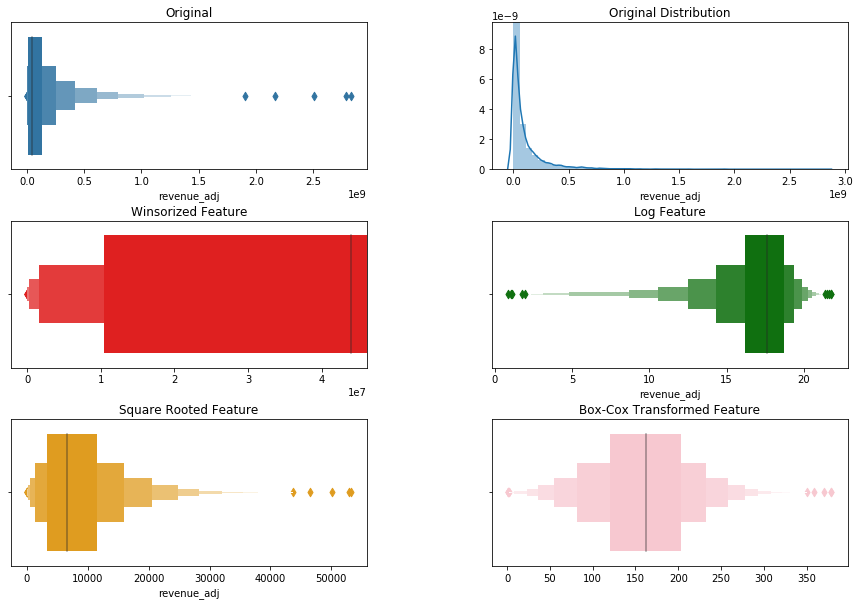

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for vc_pop feature. 









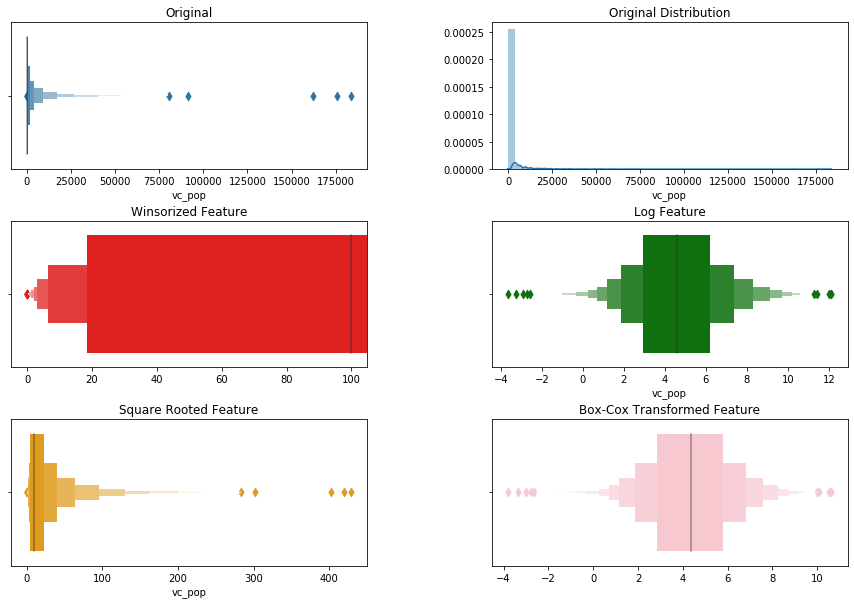

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

budget_adj Data isn't positive.

 Outlier Visualization for budget_adj feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


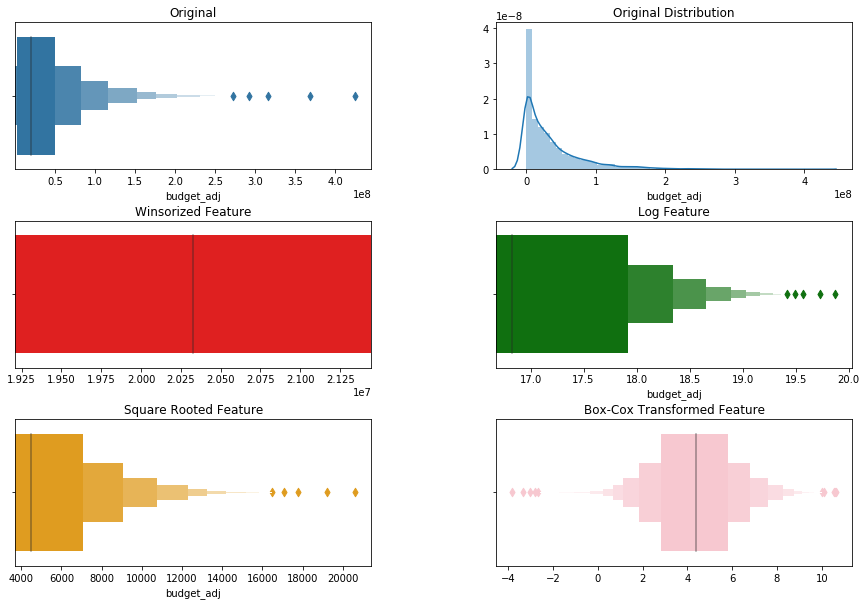


 Outlier Visualization for runtime feature. 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

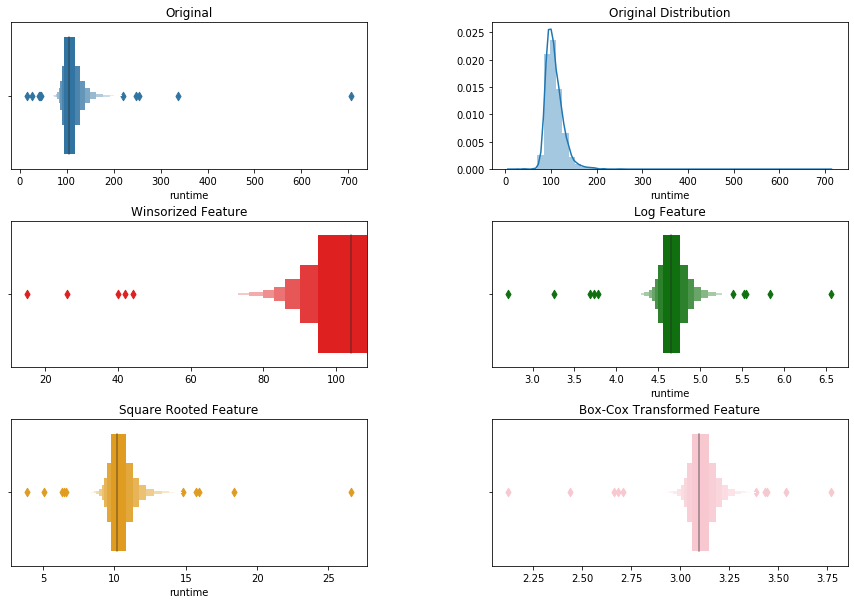

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for vote_average feature. 









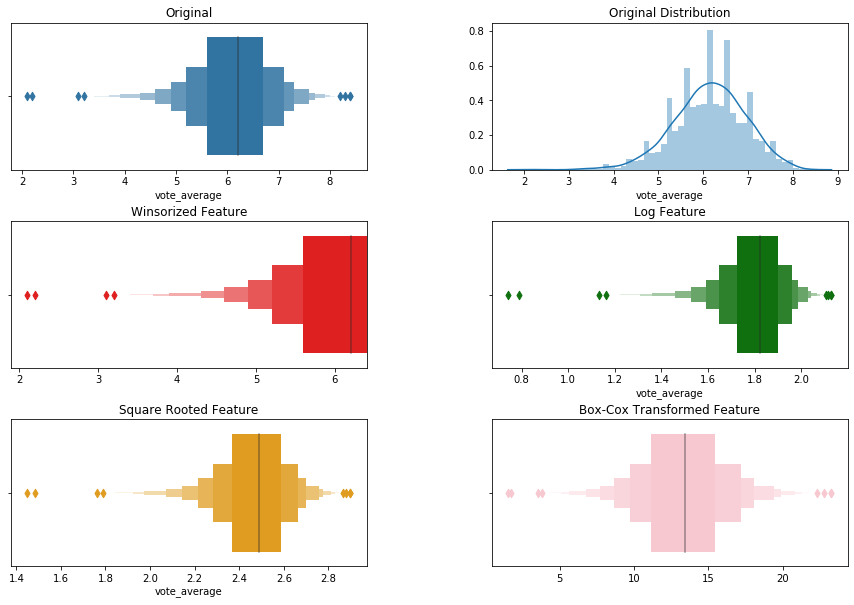

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


top_100_actors Data isn't positive.

 Outlier Visualization for top_100_actors feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


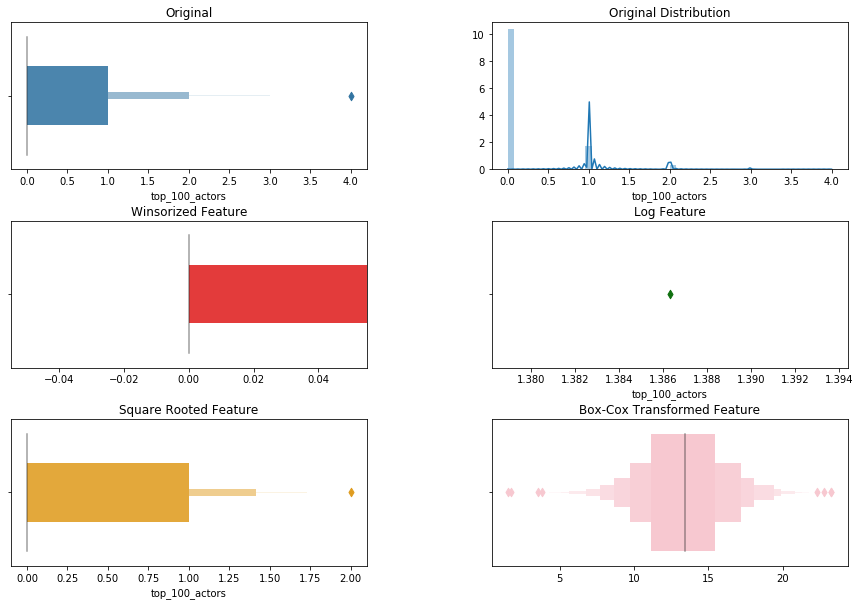

In [142]:
# Specify a list with features you want to test for normality. (You should ideally do this for all features in your dataset!)
# Visuals for outliers and normality
features_to_test = ['revenue_adj','vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors', ]

for feat in features_to_test:
    winsorized_feature = winsorize(movies[feat], (0, 0.10))
    log_feature = np.log(movies[feat])
    sqrt_feature = np.sqrt(movies[feat])
    try:
        bc_feature,_ = stats.boxcox(movies[feat])#power_transform(np.array(fifa["Wage"]).reshape(1,-1)).reshape(-1,1)
    except ValueError: 
        print(feat, 'Data isn\'t positive.')
    
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (15,10))
    plt.subplot(3, 2, 1)
    sns.boxenplot(x=feat, data=movies)
    plt.title('Original')
    print('\n')
    plt.subplot(3, 2, 2)
    sns.distplot(movies[feat])
    plt.title('Original Distribution')
    print('\n')
    plt.subplot(3, 2, 3)
    sns.boxenplot(winsorized_feature, color='red')
    plt.title('Winsorized Feature')
    plt.subplot(3, 2, 4)
    sns.boxenplot(log_feature, color='green')
    plt.title('Log Feature')
    print('\n')
    plt.subplot(3, 2, 5)
    sns.boxenplot(sqrt_feature, color='orange')
    plt.title('Square Rooted Feature')
    plt.subplot(3, 2, 6)
    sns.boxenplot(bc_feature, color='pink')
    plt.title('Box-Cox Transformed Feature')
    plt.subplots_adjust(hspace=0.35, wspace=0.35)
    plt.show()

In [143]:
# Testing to Normality

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on revenue_adj:
Jarque-Bera test statistics for revenue_adj is 226940.3455244923 and p value is 0.0
Normality test statistics for revenue_adj is 4522.292435228974 and p value is 0.0

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27345131.383749064 and p value is 0.0
Normality test statistics for vc_pop is 9645.87772348386 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 10959.419887756596 and p value is 0.0
Normality test statistics for budget_adj is 2133.926912739724 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 3797640.9538830956 and p value is 0.0
Normality test statistics for runtime is 5921.175938826389 and p value is 0.0

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 112.99050060716442 and p value is 0.0
Normality test statistics for vote_average is 102.28513371965839 and p value is 6.1

## Update Variable Values

As I was visualizing the data, there were a few values that warranted further investigation, so I have updated them here.

In [144]:
# The budget_adj for The Warrior's way appears to have an extra 0 - multiple sources have the budget at $42 million
movies.loc[2244, 'budget_adj'] = 42500000

# Band of Brothers and Carlos are miniseries which accounts for their lengthy runtimes.
# We're only interested in movies, so I'll remove them from the dataset.
movies = movies[movies.runtime < 338]

movies.sort_values(by='vote_average', ascending=False)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Romance,Horror,Animation,Foreign,Mystery,Western,History,Drama,Adventure,Family,Action,Music,War,Comedy,TV Movie,Thriller,Science Fiction,Documentary,Fantasy,Crime,top_100_actors,top_1000_actors,tagline_length,homepage_dummy,vc_pop
4178,278,tt0111161,7.192,25000000,28341469,The Shawshank Redemption,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",NaN,Frank Darabont,"[Fear, can, hold, you, prisoner., Hope, can, s...",prison|corruption|police brutality|prison cell...,Framed in the 1940s for the double murder of h...,142,Drama|Crime,Castle Rock Entertainment,9/10/1994,5754,8.400,1994,36777789.040,41693462.720,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,2,1,0,41382.992
7948,24128,tt0088178,0.283,1200000,4978922,Stop Making Sense,"[David Byrne, Tina Weymouth, Chris Frantz, Jer...",NaN,Jonathan Demme,"[Why, stop, making, sense?, Why, a, movie?, Wh...",concert,David Byrne walks onto the stage and does a so...,88,Documentary|Music,Talking Heads|Arnold Stiefel Company,11/16/1984,23,8.400,1984,2518850.447,10450966.590,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,6.513
7269,238,tt0068646,5.738,6000000,245066411,The Godfather,"[Marlon Brando, Al Pacino, James Caan, Richard...",http://www.thegodfather.com/,Francis Ford Coppola,"[An, offer, you, can't, refuse.]",italy|love at first sight|loss of father|patri...,"Spanning the years 1945 to 1955, a chronicle o...",175,Drama|Crime,Paramount Pictures|Alfran Productions,3/15/1972,3970,8.300,1972,31287365.590,1277913732.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,4,0,1,22779.995
650,244786,tt2582802,4.780,3300000,13993093,Whiplash,"[Miles Teller, J.K. Simmons, Melissa Benoist, ...",http://sonyclassics.com/whiplash/,Damien Chazelle,"[The, road, to, greatness, can, take, you, to,...",jazz|obsession|conservatory|music teacher|new ...,"Under the direction of a ruthless instructor, ...",105,Drama|Music,Bold Films|Blumhouse Productions|Right of Way ...,10/10/2014,2372,8.200,2014,3039600.468,12888912.730,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,1,11339.154
2389,55244,tt1621444,0.052,0,1339650,Bill Cunningham New York,"[Bill Cunningham, Tom Wolfe, Anna Wintour, Car...",http://billcunninghamnewyork.com/,Richard Press,"[He, who, seeks, beauty,, will, find, it.]",fashion|milliner|new york city ballet|poncho|g...,Chronicles a man who is obsessively interested...,84,Documentary,First Thought Films,3/24/2010,16,8.100,2010,0.000,1339650.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0.837
10222,424,tt0108052,2.377,22000000,321265768,Schindler's List,"[Liam Neeson, Ben Kingsley, Ralph Fiennes, Car...",http://www.schindlerslist.com/,Steven Spielberg,"[Whoever, saves, one, life,, saves, the, world...",factory|concentration camp|hero|holocaust|worl...,The true story of how businessman Oskar Schind...,195,Drama|History|War,Universal Pictures|Amblin Entertainment,11/29/1993,2632,8.100,1993,33208339.160,484941026.500,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,3,1,1,6257.022
4177,680,tt0110912,8.094,8000000,213928762,Pulp Fiction,"[John Travolta, Samuel L. Jackson, Uma Thurman...",NaN,Quentin Tarantino,"[Just, because, you, are, a, character, doesn'...",transporter|brothel|drug dealer|boxer|massage,"A burger-loving hit man, his philosophical par...",154,Thriller|Crime,Miramax Films|A Band Apart|Jersey Films,10/14/1994,5343,8.100,1994,11768892.490,314713075.100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4,1,0,43244.928
4179,13,tt0109830,6.716,55000000,677945399,Forrest Gump,"[Tom Hanks, Robin Wright, Gary Sinise, Mykelti...",NaN,Robert Zemeckis,"[The, world, will, never, be, the, same,, once...",vietnam veteran|hippie|mentally disabled|runni...,A man with a low IQ has accomplished great thi...,142,Comedy|Drama|Romance,Paramount Pictures,7/6/1994,4856,8.100,1994,80911135.890,997333314.600,1,0,0,0,0,0

## Normalizing the Features

In [145]:
# bc_revenue_adj,_ = stats.boxcox(movies['revenue_adj'])
# movies["norm_bc_revenue_adj"] = normalize(np.array(bc_revenue_adj).reshape(1,-1).reshape(-1,1))
movies["norm_winsorized_revenue_adj"] = normalize(np.array(winsorize(movies['revenue_adj'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vc_pop"] = normalize(np.array(winsorize(movies['vc_pop'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_sqrt_budget_adj"] = normalize(np.array(np.sqrt(movies['budget_adj'])).reshape(1,-1).reshape(-1,1))
movies["norm_winsorized_runtime"] = normalize(np.array(winsorize(movies['runtime'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vote_average"] = normalize(np.array(winsorize(movies['vote_average'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_100_actors"] = normalize(np.array(winsorize(movies['top_100_actors'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)


In [146]:
# Testing to Normality
features_to_test = ['norm_winsorized_revenue_adj', 'vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors', 'Adventure']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_revenue_adj:
Jarque-Bera test statistics for norm_winsorized_revenue_adj is 1123.713683320344 and p value is 0.0
Normality test statistics for norm_winsorized_revenue_adj is 732.9389443861746 and p value is 6.987638685634258e-160

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27312141.12901556 and p value is 0.0
Normality test statistics for vc_pop is 9641.034782879604 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 8349.283276825254 and p value is 0.0
Normality test statistics for budget_adj is 1978.5585603222419 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 5253.912712582582 and p value is 0.0
Normality test statistics for runtime is 1377.889780564115 and p value is 6.237862752850362e-300

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 113.7014676333856 and p value is 0.0

In [147]:
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)


,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.761
budget_adj,0.658
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.583
popularity,0.498
vc_pop,0.327
runtime,0.301


# Running the Models

All cross validation models will be run with ten folds, and all models using training and testing sets will use a 70%/30% split unless otherwise specified. Each round of models will test a new set of features.

# The first Round

For our first run, I'll use all features that have correlations of greater than 0.2 with the target variable, revenue_adj.



In [202]:
features1 = movies[['norm_winsorized_vc_pop', 'budget_adj', 'runtime',
                  'Adventure', 'norm_winsorized_100_actors', 'norm_winsorized_vote_average']]

X_train, X_test, Y_train, Y_test = train_test_split(features1, Y, test_size = .3, random_state = 465)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

## Random Forests Ensemble with Cross Validation

With scores ranging from 0.19 to 0.71 and an average of .57, we can see that while this model accounts for 57% of the data, it is not very precise or accurate. 

In [207]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = movies['norm_winsorized_revenue_adj']


# X = pd.get_dummies(X)
# X = X.dropna(axis=1)
cross_val_score(rfr, features1, Y, cv=10)


array([0.59204171, 0.65385502, 0.70695679, 0.6672837 , 0.65136053,
       0.64064469, 0.60150621, 0.53438294, 0.46210225, 0.19295459])

## OLS

With an R-squared score of 0.57, we know this model accounts for just over 50% of the variance. The Jarque-Bera probability is low indicating that we did a good job normalizing the features.

Overall, this model is better than the Random Forests model.

In [77]:
Y = movies['norm_winsorized_revenue_adj']
X = features1

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)
print("The number of observations in training set is {}".format(X.shape[0]))
print("The number of observations in test set is {}".format(X.shape[0]))
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
X_const = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X_const).fit()

# We print the summary results
print(results.summary())

The number of observations in training set is 4848
The number of observations in test set is 4848

Coefficients: 
 [3.34265735e-01 1.03583473e-10 5.04782866e-06 1.18687253e-03
 9.72165954e-02 4.05375820e-01]

Intercept: 
 -0.003877684260845572
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.571
Model:                                     OLS   Adj. R-squared:                  0.571
Method:                          Least Squares   F-statistic:                     1075.
Date:                         Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                                 18:27:19   Log-Likelihood:                 17127.
No. Observations:                         4848   AIC:                        -3.424e+04
Df Residuals:                             4841   BIC:                        -3.419e+04
Df Model:                                    6      

## OLS with SKlearn & Training Sets

The OLS model gives R-squared/adjusted values of 0.56 for the training set and 0.59 for the testing set. All of our evaluation metrics are fairly low with the exception of the mean absolute percentage error of the prediction.

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(features1, Y, test_size = .3, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# We fit an OLS model using sklearn

ols = LinearRegression().fit(X_train_const, Y_train)

results_train = sm.OLS(Y_train, X_train_const).fit()
results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = ols.predict(X_train_const)
Y_preds_test = ols.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.565
Model:                                     OLS   Adj. R-squared:                  0.564
Method:                          Least Squares   F-statistic:                     733.1
Date:                         Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                                 18:27:29   Log-Likelihood:                 11970.
No. Observations:                         3393   AIC:                        -2.393e+04
Df Residuals:                             3386   BIC:                        -2.388e+04
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                      

## Lasso Regression Model

The Lasso model with training sets performs much more poorly than the OLS model in terms of all evaluation metrics. Perhaps using the Lasso with cross validation will fare better.

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print('\n')

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

lassoregr = Lasso(alpha=1000)
#lassoregr = Lasso(alpha=.01)
# lassoregr = Lasso(alpha=.1)
# lassoregr = Lasso(alpha=.5)
# lassoregr = Lasso(alpha=1)
# lassoregr = Lasso(alpha=5) 
lassoregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = lassoregr.predict(X_train_const)
Y_preds_test = lassoregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455


R-squared of the model on the training set is: 0.4229582810613107
-----Test set statistics-----
R-squared of the model on the test set is: 0.45186070623863034
Mean absolute error of the prediction is: 0.005892761452764114
Mean squared error of the prediction is: 6.464492622273607e-05
Root mean squared error of the prediction is: 0.008040206851986836
Mean absolute percentage error of the prediction is: 2152777.535506871


## Lasso Regression Model with Cross Validation

The difference between the Lasso with cross validation and training/testing sets appears to be insignificant.

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 465)
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(n_alphas=5)
lassoregrCV.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = lassoregrCV.predict(X_train_const)
Y_preds_test = lassoregrCV.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(lassoregrCV.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregrCV.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Lasso Regression with Cross Validation:
R-squared of the model on the training set is: 0.42296230307330046
-----Test set statistics-----
R-squared of the model on the test set is: 0.4520330238612169
Mean absolute error of the prediction is: 0.005889211987064724
Mean squared error of the prediction is: 6.462460390662817e-05
Root mean squared error of the prediction is: 0.008038942959533186
Mean absolute percentage error of the prediction is: 2148323.0893113026


## Ridge Regression with Training/Testing Sets

The Ridge model performs much better than the Lasso, so I will continue to test with it as we change our features.

In [97]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(X_train_const)
Y_preds_test = ridgeregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6273393248114343
-----Test set statistics-----
R-squared of the model on the test set is: 0.6323321726413347
Mean absolute error of the prediction is: 0.004754195405185934
Mean squared error of the prediction is: 4.336098477994142e-05
Root mean squared error of the prediction is: 0.00658490582923867
Mean absolute percentage error of the prediction is: 1639066.3765763177


## Ridge Regression with Cross Validation

The Ridge with training sets performed quite a bit better than the Ridge with cross validation, so I will likely drop the latter.

In [87]:
ridgeCV = RidgeCV(alphas=(0.1, 10), cv=20)
ridgeCV.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeCV.predict(X_train_const)
Y_preds_test = ridgeCV.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeCV.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeCV.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.5566207650296846
-----Test set statistics-----
R-squared of the model on the test set is: 0.5777739932023411
Mean absolute error of the prediction is: 0.005092079284126277
Mean squared error of the prediction is: 4.979531547803576e-05
Root mean squared error of the prediction is: 0.007056579587734823
Mean absolute percentage error of the prediction is: 1479516.844404433


## ElasticNet Regression Model with Training/Testing Sets

The ElasticNet is our best model yet by a very small margin.

In [49]:
elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(X_train_const)
Y_preds_test = elasticregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.5650241395985132
-----Test set statistics-----
R-squared of the model on the test set is: 0.583101729955531
Mean absolute error of the prediction is: 0.004969889963238201
Mean squared error of the prediction is: 4.916698769116841e-05
Root mean squared error of the prediction is: 0.007011917547373786
Mean absolute percentage error of the prediction is: 1207877.0930628534


## ElasticNet Regression Model with Cross Validation

Even after playing with the number of alphas and folds, this model doesn't perform nearly as well as the ElasticNet with training/testing sets, so I'll move forward only with that model.

In [54]:
elasticregrCV = ElasticNetCV(l1_ratio=1, n_alphas=10, cv=5) 
elasticregrCV.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregrCV.predict(X_train_const)
Y_preds_test = elasticregrCV.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.42296230307330046
-----Test set statistics-----
R-squared of the model on the test set is: 0.4520330238612169
Mean absolute error of the prediction is: 0.005889211987064724
Mean squared error of the prediction is: 6.462460390662817e-05
Root mean squared error of the prediction is: 0.008038942959533186
Root mean squared error of the prediction is: 0.008038942959533186
Mean absolute percentage error of the prediction is: 2148323.0893113026


## Support Vector Machines/Regression

This is by far the worst model. Our scores have a huge range from -0.20 to -0.94, which is obviously neither precise nor accurate, as we want our scores to be as close to zero as possible. My guess is that SVR is simply a poor model for this data.

In [55]:
svr = SVR()
svr.fit(X,Y)
print('SVR Score: ', svr.score(X, Y))
cross_val_score(svr, X, Y, cv=10)

SVR Score:  -0.4389450334649936


array([-0.41219305, -0.52670471, -0.42145737, -0.47865094, -0.42534717,
       -0.94056099, -0.52612331, -0.29539793, -0.45305972, -0.20323591])

## Gradient Boosting Regressor with Training/Testing Sets

The R-squared for the training set is high at 0.79 but the value for the test set is 0.60, indicating there is gross overfitting. However, this R-squared is in line with our other models, so I'll keep working with it.

In [70]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=3, loss='ls')

gbr.fit(X_train_const, Y_train)

Y_preds_train = gbr.predict(X_train_const)
Y_preds_test = gbr.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(gbr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.7964653479492035
-----Test set statistics-----
R-squared of the model on the test set is: 0.6096926746218938
Mean absolute error of the prediction is: 0.004689457300189792
Mean squared error of the prediction is: 4.603097887787171e-05
Root mean squared error of the prediction is: 0.006784613391923796
Root mean squared error of the prediction is: 0.006784613391923796
Mean absolute percentage error of the prediction is: 829081.8962244677


# Second Round - All Features



In [168]:
features2 = movies[['budget_adj', 'norm_winsorized_vc_pop', 'vc_pop', 'runtime', 'Adventure', 'norm_winsorized_100_actors',
                    'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]

X_train, X_test, Y_train, Y_test = train_test_split(features2, Y, test_size = .3, random_state = 465)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)


## Random Forests
This is our best model yet. Our scores are more precise ranging from 0.43 to 0.79 and we're accounting for more of the data.

In [71]:
features2 = movies[['budget_adj', 'norm_winsorized_vc_pop', 'vc_pop', 'runtime', 'Adventure', 'norm_winsorized_100_actors',
                    'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]


rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = movies['norm_winsorized_revenue_adj']
rfr.fit(features2,Y)

print(cross_val_score(rfr, features2, Y, cv=10))

[0.77578104 0.75285043 0.79062386 0.73803392 0.758837   0.75009975
 0.72153168 0.63358013 0.58165131 0.42323822]


## OLS

We've increased the R-squared to 0.64/0.63 for the training and test sets. While the AIC and BIC for the training set is low, it's absurdly high for the test set. What's going on here?

In [93]:
Y = movies['norm_winsorized_revenue_adj']


print("The number of observations in training set is {}.".format(X_train.shape[0]))
print("The number of observations in test set is {}.".format(X_test.shape[0]))


# We fit an OLS model using statsmodels
results_train = sm.OLS(Y_train, X_train_const).fit()


results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print('\n')
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = results_train
Y_preds_test = results_test

The number of observations in training set is 3393.
The number of observations in test set is 1455.


                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.636
Model:                                     OLS   Adj. R-squared:                  0.633
Method:                          Least Squares   F-statistic:                     202.8
Date:                         Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                                 18:38:21   Log-Likelihood:                 12274.
No. Observations:                         3393   AIC:                        -2.449e+04
Df Residuals:                             3363   BIC:                        -2.430e+04
Df Model:                                   29                                         
Covariance Type:                     nonrobust                                         
                  

## OLS with Sklearn

In [101]:
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn

ols = LinearRegression().fit(X_train_const, Y_train)

results_train = sm.OLS(Y_train, X_train_const).fit()
results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = ols.predict(X_train_const)
Y_preds_test = ols.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.636
Model:                                     OLS   Adj. R-squared:                  0.633
Method:                          Least Squares   F-statistic:                     202.8
Date:                         Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                                 18:43:28   Log-Likelihood:                 12274.
No. Observations:                         3393   AIC:                        -2.449e+04
Df Residuals:                             3363   BIC:                        -2.430e+04
Df Model:                                   29                                         
Covariance Type:                     nonrobust                                         
                      

## Ridge Regression with Training/Testing Sets

Why are the evaluation metrics not changing? They're identical to the metrics of the models using the previous features, but the OLS is changing...

In [103]:
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(X_train_const)
Y_preds_test = ridgeregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6273393248114343
-----Test set statistics-----
R-squared of the model on the test set is: 0.6323321726413347
Mean absolute error of the prediction is: 0.004754195405185934
Mean squared error of the prediction is: 4.3360984779941416e-05
Root mean squared error of the prediction is: 0.00658490582923867
Mean absolute percentage error of the prediction is: 1639066.3765763177


## Ridge With Cross Validation

Evaluation metrics are identical to those of the previous Ridge model (training/testing sets), no matter how I change the folds and alphas.

In [96]:
ridgeCV = RidgeCV(alphas=(0.1, 10), cv=5)
ridgeCV.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeCV.predict(X_train_const)
Y_preds_test = ridgeCV.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeCV.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeCV.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6273393248114343
-----Test set statistics-----
R-squared of the model on the test set is: 0.6323321726413347
Mean absolute error of the prediction is: 0.004754195405185934
Mean squared error of the prediction is: 4.336098477994142e-05
Root mean squared error of the prediction is: 0.00658490582923867
Mean absolute percentage error of the prediction is: 1639066.3765763177


## ElasticNet With Training/Testing Sets

This model is comparable to the OLS model.

In [104]:
elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(X_train_const)
Y_preds_test = elasticregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6362436298266617
-----Test set statistics-----
R-squared of the model on the test set is: 0.6379997423845187
Mean absolute error of the prediction is: 0.004656676365865894
Mean squared error of the prediction is: 4.269257871586194e-05
Root mean squared error of the prediction is: 0.006533955824449836
Mean absolute percentage error of the prediction is: 1593479.8783453526


## Gradient Boosting 

In [169]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=3, loss='ls')

gbr.fit(X_train_const, Y_train)

Y_preds_train = gbr.predict(X_train_const)
Y_preds_test = gbr.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(gbr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.8731842578942485
-----Test set statistics-----
R-squared of the model on the test set is: 0.7023875008924394
Mean absolute error of the prediction is: 0.004011853012675689
Mean squared error of the prediction is: 3.509899448323085e-05
Root mean squared error of the prediction is: 0.0059244404362969886
Root mean squared error of the prediction is: 0.0059244404362969886
Mean absolute percentage error of the prediction is: 1005747.3405286418


## SVR

Not just terrible, but exactly the same. Why is nothing changing?

In [105]:
X = movies[['budget_adj', 'norm_winsorized_vc_pop', 'vc_pop', 'runtime', 'Adventure', 'norm_winsorized_100_actors',
                    'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]
svr = SVR()
svr.fit(features2,Y)
print('SVR Score: ', svr.score(features2, Y))
cross_val_score(svr, features2, Y, cv=10)

SVR Score:  -0.4389450334649936


array([-0.41219305, -0.52670471, -0.42145737, -0.47865094, -0.42534717,
       -0.94056099, -0.52612331, -0.29539793, -0.45305972, -0.20323591])

## New Variables

After running a few models, I'm going to create some new variables. Concerning the cast column and our new variable top_100_stars, below we can see that this new variable is not well-distributed. I'm going to pull in a list of top 1,000 actors and see if that makes a difference.

Additionally, I'll look at the top 100 Production Companies.

Finally, it could be interesting to see whether film adaptations of books fare better, so I'll pull in a list of books that have been made into films.

In [148]:
print('Number of movies for each number of stars in top_100_stars (0-5): \n', movies.top_100_actors.value_counts())

# Importing the top 1000 actors 

top_1000_actors = pd.read_csv('top_1000_actors.csv')
top_1000_actors = pd.DataFrame(top_1000_actors)


# Converting the series to a list so we can compare it to the cast lists
top_1000_actors = top_1000_actors['Name'].tolist()
print('\n Testing the list: ', top_1000_actors[:5], '\n')

movies['top_1000_stars'] = [len(set(i) & set(top_1000_actors)) for i in movies['cast']]
print('Number of movies for each number of stars in top_1000_stars (0-5): \n', movies.top_1000_stars.value_counts())

Number of movies for each number of stars in top_100_stars (0-5): 
 0    4020
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64

 Testing the list:  ['Robert De Niro', 'Jack Nicholson', 'Marlon Brando', 'Denzel Washington', 'Clark Gable'] 

Number of movies for each number of stars in top_1000_stars (0-5): 
 2    1120
1    1029
3     975
0     866
4     616
5     242
Name: top_1000_stars, dtype: int64


In [150]:
# Create a list of genres

PCs = movies.production_companies
pcs = []  # Each movie's production companies as a list, without the '|'
flatten_pcs = [] # All of the production companies as a single list

for list_of_pcs in PCs:
    movies_pcs = list_of_pcs.split('|')
    pcs.append(movies_pcs)
    for i in range(len(pcs)): #Traversing through the main list
        for j in range (len(pcs[i])): #Traversing through each sublist
            flatten_pcs.append(pcs[i][j]) #Appending elements into our flat_list
        


unique_pcs = set(flatten_pcs)
unique_pcs = list(unique_pcs)
print(len(unique_pcs))



3929


In [151]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: x.split('|'))# Making the production_companies variable into lists

In [152]:

print('Number of production companies: ', len(unique_pcs), '\n')
print('First five unique production companies: ', unique_pcs[:5], '\n')
print('First five lists of production companies: ', pcs[:5], '\n')
print('First five elements of flatten_pcs: ', flatten_pcs[:5])
print('Length of flatten_pcs: ', len(flatten_pcs))

Number of production companies:  3929 

First five unique production companies:  ['Peters Entertainment', 'Canal Plus', 'Latitude Media', 'Robert H. Solo Productions', 'Marvel Entertainment'] 

First five lists of production companies:  [['Universal Studios', 'Amblin Entertainment', 'Legendary Pictures', 'Fuji Television Network', 'Dentsu'], ['Village Roadshow Pictures', 'Kennedy Miller Productions'], ['Summit Entertainment', 'Mandeville Films', 'Red Wagon Entertainment', 'NeoReel'], ['Lucasfilm', 'Truenorth Productions', 'Bad Robot'], ['Universal Pictures', 'Original Film', 'Media Rights Capital', 'Dentsu', 'One Race Films']] 

First five elements of flatten_pcs:  ['Universal Studios', 'Amblin Entertainment', 'Legendary Pictures', 'Fuji Television Network', 'Dentsu']
Length of flatten_pcs:  33533177


In [153]:
# Production companies frequency dictionary to obtain the biggest/most common companies
pc_freqdict = {}
pcs = tuple(pcs)

for companies in pcs:
    for company in companies:
        if company in pc_freqdict:
            pc_freqdict[company] += 1
        else:
            pc_freqdict[company] = 1
    
print(type(pc_freqdict.keys()))
sorted(pc_freqdict.keys())
top_pcs = []

for key in pc_freqdict.keys():
    if pc_freqdict[key] > 14:
        top_pcs.append(key)
        
print(len(top_pcs))

<class 'dict_keys'>
97


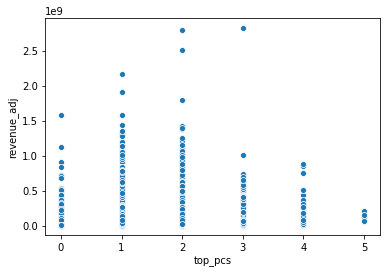

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


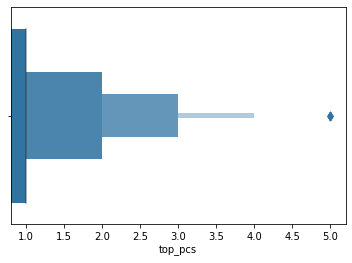

In [154]:
# Creating a new column called 'top_pcs' that will represent the number of top production companies 
# involved in a movie

movies['top_pcs'] = [len(set(i) & set(top_pcs)) for i in movies['production_companies']]
sns.scatterplot(x='top_pcs', y='revenue_adj', data=movies)
plt.show()

sns.boxenplot(x='top_pcs', data=movies)

In [113]:
movies.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Romance,Horror,Animation,Foreign,Mystery,Western,History,Drama,Adventure,Family,Action,Music,War,Comedy,TV Movie,Thriller,Science Fiction,Documentary,Fantasy,Crime,top_100_actors,tagline_length,homepage_dummy,vc_pop,norm_winsorized_revenue_adj,norm_winsorized_vc_pop,norm_sqrt_budget_adj,norm_winsorized_runtime,norm_winsorized_vote_average,norm_winsorized_100_actors,top_1000_stars,top_pcs
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,"[The, park, is, open.]",monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,"[Universal Studios, Amblin Entertainment, Lege...",6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,183466.814,0.033,0.037,1.000,0.017,0.015,0.000,2,2
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,"[What, a, Lovely, Day.]",future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,"[Village Roadshow Pictures, Kennedy Miller Pro...",5/13/2015,6185,7.100,2015,137999939.300,348161292.500,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,175777.304,0.033,0.037,1.000,0.016,0.017,0.035,3,1
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,"[One, Choice, Can, Destroy, You]",based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,"[Summit Entertainment, Mandeville Films, Red W...",3/18/2015,2480,6.300,2015,101199955.500,271619025.400,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,32519.017,0.029,0.037,1.000,0.016,0.015,0.035,3,1
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,"[Every, generation, has, a, story.]",android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,"[Lucasfilm, Truenorth Productions, Bad Robot]",12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,59128.066,0.033,0.037,1.000,0.018,0.017,0.035,4,1
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",http://www.furious7.com/,James Wan,"[Vengeance, Hits, Home]",car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,"[Universal Pictures, Original Film, Media Righ...",4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,27510.286,0.033,0.037,1.000,0.018,0.017,0.000,5,2


In [155]:
# Importing the book__film_adaptations 

book_film_adaptations = pd.read_csv('book_film_adaptations.csv')
book_films = pd.DataFrame(book_film_adaptations)


# Removing *s and years
book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.strip('*'))
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.replace(u'\xa0', u' ')
titles_split = book_films['Film_adaptation'].str.split('(', n=1, expand=True)
book_films['Film_adaptation'] = titles_split[0]
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.rstrip()
# book_films['Film_adaptation'] = book_films['Film_adaptation'].str.split('(')

# book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.split(' (', 1)[0])

# Converting the series to a list so we can compare it to the cast lists
book_films = book_films['Film_adaptation'].tolist()
print('\n Testing the list: ', book_films[72:77], '\n')

movies['books'] = [len(set(i) & set(book_films)) for i in movies['original_title']]
print('Number of movies adapted from books: \n', movies.books.value_counts())


 Testing the list:  ['Tom Sawyer', ' Huckleberry Finn', 'Tom Sawyer', 'The Adventures of Mark Twain', 'Back to Hannibal: The Return of Tom Sawyer and Huckleberry Finn'] 

Number of movies adapted from books: 
 0    4451
1     397
Name: books, dtype: int64


In [158]:
# Normalizing new feature

movies['norm_winsorized_top_1000_stars'] = normalize(np.array(winsorize(movies['top_1000_stars'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies['norm_winsorized_top_pcs'] = normalize(np.array(winsorize(movies['top_pcs'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)

features_to_test = ['norm_winsorized_top_1000_stars', 'top_1000_stars', 'norm_winsorized_top_pcs', 'top_pcs']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))


Testing for normality on norm_winsorized_top_1000_stars:
Jarque-Bera test statistics for norm_winsorized_top_1000_stars is 285.6854074833741 and p value is 0.0
Normality test statistics for norm_winsorized_top_1000_stars is 3726.9083415593186 and p value is 0.0

Testing for normality on top_1000_stars:
Jarque-Bera test statistics for top_1000_stars is 198.49302586769141 and p value is 0.0
Normality test statistics for top_1000_stars is 625.5989558126938 and p value is 1.4220432429128338e-136

Testing for normality on norm_winsorized_top_pcs:
Jarque-Bera test statistics for norm_winsorized_top_pcs is 212.00026473128594 and p value is 0.0
Normality test statistics for norm_winsorized_top_pcs is 1227.1251974830047 and p value is 3.413100405053702e-267

Testing for normality on top_pcs:
Jarque-Bera test statistics for top_pcs is 892.9157555077314 and p value is 0.0
Normality test statistics for top_pcs is 601.6977991126896 and p value is 2.202840416175467e-131



In [159]:
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)

,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.761
budget_adj,0.658
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.583
popularity,0.498
norm_winsorized_top_pcs,0.365
top_pcs,0.346


## Testing Our Models With Three New Variables

In [170]:
features3 = movies[['budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_top_pcs', 'runtime', 'top_1000_stars',
                    'Adventure', 'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'books', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]

Y = movies['norm_winsorized_revenue_adj'] 
X_train, X_test, Y_train, Y_test = train_test_split(features3, Y, test_size = .3, random_state = 465)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)


## Random Forests

Still not a great model, ranging from 0.43 to 0.78

In [162]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = movies['norm_winsorized_revenue_adj']
rfr.fit(features3 ,Y)

print('Feature Importance: ', rfr.feature_importances_)
print(cross_val_score(rfr, features3, Y, cv=10))

Feature Importance:  [2.62536007e-01 4.29203662e-01 1.36339881e-02 4.19467931e-02
 1.62547552e-02 4.41411849e-03 3.84763671e-02 4.52868284e-03
 3.76652567e-03 1.86866388e-03 2.95461607e-03 4.34551742e-03
 5.02204819e-03 1.44735316e-03 4.59588504e-03 3.14158422e-03
 1.25227895e-03 5.39818209e-03 1.27255048e-03 4.08037914e-05
 3.36756631e-03 7.63306163e-03 3.92429607e-03 2.76063787e-03
 5.82308681e-03 1.78361114e-05 3.56452095e-03 3.21433758e-04
 1.22120208e-01 4.36697044e-03]
[0.7702903  0.75487796 0.78533791 0.75265209 0.75524495 0.74829107
 0.72367232 0.63634194 0.58650773 0.43350738]


## OLS

In [163]:
print("The number of observations in training set is {}.".format(X_train.shape[0]))
print("The number of observations in test set is {}.".format(X_test.shape[0]))

# We fit an OLS model using statsmodels
results_train = sm.OLS(Y_train, X_train_const).fit()


results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print('\n')
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = results_train
Y_preds_test = results_test

The number of observations in training set is 3393.
The number of observations in test set is 1455.


                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.638
Model:                                     OLS   Adj. R-squared:                  0.635
Method:                          Least Squares   F-statistic:                     197.3
Date:                         Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                                 19:10:44   Log-Likelihood:                 12281.
No. Observations:                         3393   AIC:                        -2.450e+04
Df Residuals:                             3362   BIC:                        -2.431e+04
Df Model:                                   30                                         
Covariance Type:                     nonrobust                                         
                  

## Ridge Regression with Training/Testing Sets

Exact same metrics as Ridge with cross validation.

In [164]:
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(X_train_const)
Y_preds_test = ridgeregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6289929595717147
-----Test set statistics-----
R-squared of the model on the test set is: 0.6340574976021778
Mean absolute error of the prediction is: 0.004760912274894505
Mean squared error of the prediction is: 4.315750820733777e-05
Root mean squared error of the prediction is: 0.006569437434616283
Mean absolute percentage error of the prediction is: 1598557.4323939637


## Ridge Regression with Cross Validation

Exact same metrics as Ridge with training/testing sets.

In [165]:
ridgeCV = RidgeCV(alphas=(0.1, 10), cv=5)
ridgeCV.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeCV.predict(X_train_const)
Y_preds_test = ridgeCV.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeCV.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeCV.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6289929595717147
-----Test set statistics-----
R-squared of the model on the test set is: 0.6340574976021778
Mean absolute error of the prediction is: 0.004760912274894505
Mean squared error of the prediction is: 4.315750820733777e-05
Root mean squared error of the prediction is: 0.006569437434616283
Mean absolute percentage error of the prediction is: 1598557.4323939637


## ElasticNet with Training/Testing Sets

Slightly better than last model.

In [167]:
elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(X_train_const)
Y_preds_test = elasticregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6377491502712468
-----Test set statistics-----
R-squared of the model on the test set is: 0.6407327930472646
Mean absolute error of the prediction is: 0.004665171816466477
Mean squared error of the prediction is: 4.2370255794540554e-05
Root mean squared error of the prediction is: 0.006509243872719822
Mean absolute percentage error of the prediction is: 1620689.7579724628


## Gradient Boosting

While the discrepancy between the R-squareds in the training and tests sets differ greatly, the R-squared for the test set for the Gradient Boosting model is much better than any other model. However, the previous set of features produced a slightly higher R-squared and lower evaluation metrics.

In [171]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=3, loss='ls')

gbr.fit(X_train_const, Y_train)

Y_preds_train = gbr.predict(X_train_const)
Y_preds_test = gbr.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(gbr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.87058065118805
-----Test set statistics-----
R-squared of the model on the test set is: 0.7021839573764244
Mean absolute error of the prediction is: 0.004036609587671325
Mean squared error of the prediction is: 3.512299943183727e-05
Root mean squared error of the prediction is: 0.005926466015412328
Root mean squared error of the prediction is: 0.005926466015412328
Mean absolute percentage error of the prediction is: 1017477.6160971759


# Last Set of Features

Using the informtion from the OLS models, I'll remove any featrues with a p-value greater than 0.1.

In [174]:
features4 = movies[['budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_top_pcs', 'runtime', 
                    'Family', 'Animation', 'Fantasy', 'Science Fiction', 'TV Movie', 'Comedy',
                    'Crime',  'release_year']]

Y = movies['norm_winsorized_revenue_adj'] 
X_train, X_test, Y_train, Y_test = train_test_split(features4, Y, test_size = .3, random_state = 465)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

### Random Forests with Features4

In [175]:

rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = movies['norm_winsorized_revenue_adj']

rfr.fit(features4,Y)
# X = pd.get_dummies(X)
# X = X.dropna(axis=1)
print('Feature Importance: ', rfr.feature_importances_)
# rfr.fit(X, Y)
print(cross_val_score(rfr, features4, Y, cv=10))


Feature Importance:  [2.81341110e-01 4.55934220e-01 1.87690971e-02 6.72711476e-02
 5.67641004e-03 2.63257248e-03 5.06797377e-03 7.80391435e-03
 4.86103828e-05 1.20220187e-02 6.86907204e-03 1.36563853e-01]
[0.77125033 0.73476851 0.77086323 0.73304612 0.74086873 0.75391299
 0.69872328 0.60098555 0.55578259 0.40429533]


## OLS with Features4

In [176]:
print("The number of observations in training set is {}.".format(X_train.shape[0]))
print("The number of observations in test set is {}.".format(X_test.shape[0]))

# We fit an OLS model using statsmodels
results_train = sm.OLS(Y_train, X_train_const).fit()


results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print('\n')
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = results_train
Y_preds_test = results_test

The number of observations in training set is 3393.
The number of observations in test set is 1455.


                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.632
Model:                                     OLS   Adj. R-squared:                  0.630
Method:                          Least Squares   F-statistic:                     483.3
Date:                         Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                                 11:34:55   Log-Likelihood:                 12253.
No. Observations:                         3393   AIC:                        -2.448e+04
Df Residuals:                             3380   BIC:                        -2.440e+04
Df Model:                                   12                                         
Covariance Type:                     nonrobust                                         
                  

## Ridge Regression with Training/Testing Sets

In [177]:
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(X_train_const)
Y_preds_test = ridgeregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6230125934265303
-----Test set statistics-----
R-squared of the model on the test set is: 0.6395964042985607
Mean absolute error of the prediction is: 0.004701365573709655
Mean squared error of the prediction is: 4.250427604752444e-05
Root mean squared error of the prediction is: 0.006519530354828056
Mean absolute percentage error of the prediction is: 1714701.4012296186


## ElasticNet with Training/Testing Sets

In [193]:
elasticregr = ElasticNet(l1_ratio=0.5, max_iter=100, alpha=0) 
elasticregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(X_train_const)
Y_preds_test = elasticregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6317762657228307
-----Test set statistics-----
R-squared of the model on the test set is: 0.6431227947630579
Mean absolute error of the prediction is: 0.004632805510910899
Mean squared error of the prediction is: 4.208839042501108e-05
Root mean squared error of the prediction is: 0.006487556583569124
Mean absolute percentage error of the prediction is: 1617212.3894685172


## Gradient Boosting

As expected, this model gives the best R-squared values and evaluation metrics for this round of features.

In [181]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=3, loss='ls')

gbr.fit(X_train_const, Y_train)

Y_preds_train = gbr.predict(X_train_const)
Y_preds_test = gbr.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(gbr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.8557501773322873
-----Test set statistics-----
R-squared of the model on the test set is: 0.6825232516162281
Mean absolute error of the prediction is: 0.0041178448018677465
Mean squared error of the prediction is: 3.744168902008657e-05
Root mean squared error of the prediction is: 0.00611896143312626
Root mean squared error of the prediction is: 0.00611896143312626
Mean absolute percentage error of the prediction is: 880552.1911728529
